In [1]:
import pandas as pd
import numpy as np
import re

## National cronavirus index and heat map

In [4]:
population = pd.read_excel('population.xlsx')
population['地区']=population['地区'].apply(lambda x:x[:2])
population['地区'][population['地区']=='黑龙'] = '黑龙江'
population['地区'][population['地区']=='内蒙'] = '内蒙古'
population['地区']
population=population.rename(columns={population.columns[1]:'population'})
patient = pd.read_csv('provincial output\province_update_2020-01-30.csv')
patient=patient.rename(columns={patient.columns[0]:'地区', patient.columns[1]:'Confirmed'})
pop_patient = pd.merge(patient, population, how='left', on='地区')
pop_patient=pop_patient.rename(columns={pop_patient.columns[2]:'population'})
pop_patient.loc[pop_patient['地区']=='澳门','population']=62
pop_patient.loc[pop_patient['地区']=='香港','population']=739
pop_patient.loc[pop_patient['地区']=='台湾','population']=2378
pop_patient['pop_patient_ratio']=np.log(pop_patient['Confirmed']/pop_patient['population'])
# pop_patient['n_pop_p_ratio']=(pop_patient['pop_patient_ratio']-pop_patient['pop_patient_ratio'].mean())/pop_patient['pop_patient_ratio'].std()
pop_patient['n_pop_p_ratio']=(pop_patient['pop_patient_ratio']-pop_patient['pop_patient_ratio'].min())/(pop_patient['pop_patient_ratio'].max()-pop_patient['pop_patient_ratio'].min())
pop_patient=pop_patient.sort_values(by=['n_pop_p_ratio'],ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
from functools import reduce
patientlag = pd.read_csv('provincial output\province_update_2020-01-29.csv')
patientlag2= pd.read_csv('provincial output\province_update_2020-01-28.csv')
patientlag=patientlag.rename(columns={patientlag.columns[0]:'地区', patientlag.columns[1]:'Confirmedlag'})
patientlag2=patientlag2.rename(columns={patientlag2.columns[0]:'地区', patientlag2.columns[1]:'Confirmedlag2'})
data_frames = [patient, patientlag, patientlag2]
patientgrowth = reduce(lambda  left,right: pd.merge(left,right,on=['地区'],
                                            how='left'), data_frames)
patientgrowth=patientgrowth.replace([np.inf, -np.inf], 0)
# patientgrowth = pd.merge(patient, patientlag, how='left', on='地区')
patientgrowth['patientgrowth']=(patientgrowth['Confirmed']-patientgrowth['Confirmedlag'])/patientgrowth['Confirmedlag']
patientgrowth['growthchange']=patientgrowth['patientgrowth']-(patientgrowth['Confirmedlag']-patientgrowth['Confirmedlag2'])/patientgrowth['Confirmedlag2']

patientgrowth['n_patientgrowth']=(patientgrowth['patientgrowth']-patientgrowth['patientgrowth'].min())/(patientgrowth['patientgrowth'].max()-patientgrowth['patientgrowth'].min())
patientgrowth['n_growthchange']=(patientgrowth['growthchange']-patientgrowth['growthchange'].min())/(patientgrowth['growthchange'].max()-patientgrowth['growthchange'].min())
patientgrowth=patientgrowth.fillna(0)
patientgrowth['increase_port'] = np.log((patientgrowth['Confirmed']- patientgrowth['Confirmedlag'])/(patientgrowth['Confirmed']- patientgrowth['Confirmedlag']).sum())
patientgrowth['n_increase_port']=(patientgrowth['increase_port']-patientgrowth['increase_port'].min())/(patientgrowth['increase_port'].max()-patientgrowth['increase_port'].min())


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


(array([3., 1., 2., 6., 5., 5., 8., 2., 0., 2.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

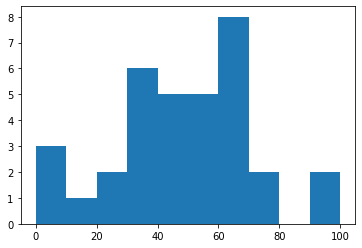

In [15]:
n_growth_pop= pd.merge(pop_patient[['地区', 'population', 'pop_patient_ratio', 'n_pop_p_ratio']], patientgrowth, how ='inner', on=['地区'])
# n_growth_pop['index']=1*n_growth_pop['n_pop_p_ratio'] +0.5*n_growth_pop['n_patientgrowth'] + 0.5*n_growth_pop['n_growthchange']+ 1*n_growth_pop['n_increase_port']
n_growth_pop['index']=1*n_growth_pop['n_pop_p_ratio'] +1*n_growth_pop['n_patientgrowth'] + 1*n_growth_pop['n_growthchange']
n_growth_pop['index']=round(n_growth_pop['index']/n_growth_pop['index'].max()*100,1)
import matplotlib.pyplot as plt
plt.hist(n_growth_pop['index'])

In [9]:
result = n_growth_pop[['地区','index']]
result=result.set_index(['地区']).sort_values(by=['index'], ascending=False)
print(result)

     index
地区        
湖北   100.0
江西    96.2
宁夏    79.4
浙江    72.5
云南    69.8
黑龙江   68.4
重庆    67.9
上海    67.8
河南    63.6
广东    62.7
江苏    62.3
青海    61.4
四川    55.0
安徽    53.0
福建    51.2
海南    50.7
山东    50.4
河北    49.6
香港    45.8
北京    44.8
天津    41.1
澳门    40.5
贵州    37.4
陕西    35.8
内蒙古   35.6
广西    35.4
辽宁    34.6
甘肃    30.2
山西    29.5
湖南    29.0
台湾    19.6
新疆     7.3
吉林     6.4
西藏     0.0


In [10]:
# https://pyecharts.org/#/zh-cn/geography_charts?id=map%ef%bc%9a%e5%9c%b0%e5%9b%be
from pyecharts import options as opts
from pyecharts.charts import Map
from datetime import datetime
import math

# data structure example below:
# province_distribution = {'河南': 45.23, '北京': 37.56, '河北': 21, '辽宁': 12, '江西': 6, '上海': 20, '安徽': 10, '江苏': 16, '湖南': 9,'浙江': 13, '海南': 2, '广东': 22, '湖北': 8, '黑龙江': 11, '澳门': 1, '陕西': 11, '四川': 7, '内蒙古': 3, '重庆': 3,'云南': 6, '贵州': 2, '吉林': 3, '山西': 12, '山东': 11, '福建': 4, '青海': 1, '天津': 1,'其他': 1}
# provice = list(data.keys())
# values = list(data.values())

def map_base() -> Map:
    c = (
        Map()
        .add("", [list(z) for z in zip(n_growth_pop['地区'], n_growth_pop['index'])], "china")
        .set_global_opts(
            title_opts=opts.TitleOpts(title="树洞冠状病毒综合指数，构成: 1.log(确诊/人口)；2.增长率；3.增长变化率，标准化等权重求和，更新至{}".format(str(datetime.today().date())[5:10])),
            visualmap_opts=opts.VisualMapOpts(max_=math.ceil(n_growth_pop['index'].max())),
        )
    )
    return c
map=map_base()

map.render('树洞冠状病毒综合指数热力图.html')

'F:\\向菁\\virus\\树洞冠状病毒综合指数热力图.html'

## Grabbing and plotting inner province index heat map

### First read and process data from sentence

In [4]:
provincequote = "武汉市13603例、孝感市2313例、黄冈市2041例、随州市953例、荆州市941例、襄阳市907例、黄石市703例、宜昌市633例、荆门市588例、鄂州市569例、咸宁市476例、十堰市438例、仙桃市359例、天门市179例、恩施州160例、潜江市80例、神农架林区10例。已治愈出院1115例"
provincequote=re.split('[，、]' ,provincequote)
re_cityname = re.compile(u"[\u4e00-\u9fa5]+")
re_citynum = re.compile('[0-9]+')
citylist=[re_cityname.search(region,0)[0] for region in provincequote]
numlist=[re_citynum.search(region,0)[0] for region in provincequote]

todaydate = '2020-02-07'
# generate dataframe and save properly
wh = pd.DataFrame(list(zip(citylist, numlist)), columns =['地区',todaydate]) 
wh.set_index(['地区'], inplace=True)
wh.to_csv('hubei\hubei_{}.csv'.format(todaydate), encoding='utf_8_sig')

In [5]:
whindex = pd.read_csv('hubei\hubei_2020-02-07.csv').rename(columns={'2020-02-07':'Confirmed'})
whindex = pd.merge(whindex,pd.read_csv('hubei\hubei_2020-02-06.csv').rename(columns={'2020-02-06':'Confirmedlag'}),how='left',on='地区')
whindex = pd.merge(whindex,pd.read_csv('hubei\hubei_2020-02-05.csv').rename(columns={'2020-02-05':'Confirmedlag2'}),how='left',on='地区')
whindex = pd.merge(whindex,pd.read_csv('hubei\hubei_population.csv'),how='left',on='地区')
whindex.loc[whindex['地区']=='恩施州','地区']='恩施土家族苗族自治州'

### Then form a combined dataframe to construct index

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


(array([1., 2., 2., 2., 4., 2., 2., 0., 1., 1.]),
 array([  2.9 ,  12.61,  22.32,  32.03,  41.74,  51.45,  61.16,  70.87,
         80.58,  90.29, 100.  ]),
 <a list of 10 Patch objects>)

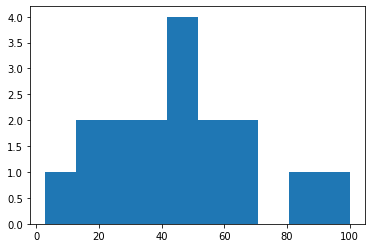

In [8]:
whindex['pop_patient_ratio']=np.log(whindex['Confirmed']/whindex['population'])
# pop_patient['n_pop_p_ratio']=(pop_patient['pop_patient_ratio']-pop_patient['pop_patient_ratio'].mean())/pop_patient['pop_patient_ratio'].std()
whindex['n_pop_p_ratio']=(whindex['pop_patient_ratio']-whindex['pop_patient_ratio'].min())/(whindex['pop_patient_ratio'].max()-whindex['pop_patient_ratio'].min())

whindex['patientgrowth']=(whindex['Confirmed']-whindex['Confirmedlag'])/whindex['Confirmedlag']
whindex['growthchange']=whindex['patientgrowth']-(whindex['Confirmedlag']-whindex['Confirmedlag2'])/whindex['Confirmedlag2']

whindex['n_patientgrowth']=(whindex['patientgrowth']-whindex['patientgrowth'].min())/(whindex['patientgrowth'].max()-whindex['patientgrowth'].min())
whindex['n_growthchange']=(whindex['growthchange']-whindex['growthchange'].min())/(whindex['growthchange'].max()-whindex['growthchange'].min())
whindex['increase_port'] = np.log((whindex['Confirmed']- whindex['Confirmedlag'])/(whindex['Confirmed']- whindex['Confirmedlag']).sum())
whindex[['increase_port']]=whindex[['increase_port']].replace([np.inf, -np.inf], np.nan)
whindex['increase_port'] = np.where(whindex['increase_port'].notna(),whindex['increase_port'],whindex['increase_port'].min())
whindex['n_increase_port']=(whindex['increase_port']-whindex['increase_port'].min())/(whindex['increase_port'].max()-whindex['increase_port'].min())

whindex=whindex.fillna(0)


whindex['index']=1*whindex['n_pop_p_ratio'] + 0.5*whindex['n_patientgrowth'] + 0.5*whindex['n_growthchange'] + 1*(whindex['n_increase_port'])
whindex['index']=round(whindex['index']/whindex['index'].max()*100,1)
whindex=whindex.sort_values(by=['index'],ascending=False)
import matplotlib.pyplot as plt
plt.hist(whindex['index'])

In [7]:
whindex

,地区,Confirmed,Confirmedlag,Confirmedlag2,population,pop_patient_ratio,n_pop_p_ratio,patientgrowth,growthchange,n_patientgrowth,n_growthchange,increase_port,n_increase_port,index
0,武汉市,13603,11618,10117,1067,2.545439,1.000000,0.170856,0.022491,0.821153,0.594007,-0.358537,1.000000,100.0
9,鄂州市,569,471,423,106,1.680441,0.736153,0.208068,0.094593,1.000000,1.000000,-3.366944,0.536795,83.9
2,黄冈市,2041,1897,1807,573,1.270309,0.611052,0.075909,0.026103,0.364830,0.614344,-2.982098,0.596050,62.7
12,仙桃市,359,307,265,116,1.129732,0.568172,0.169381,0.010891,0.814066,0.528684,-4.000668,0.439220,62.0
1,孝感市,2313,2141,1886,488,1.555985,0.698191,0.080336,-0.054870,0.386106,0.158393,-2.804417,0.623407,58.9
6,黄石市,703,635,566,246,1.050025,0.543860,0.107087,-0.014822,0.514671,0.383903,-3.732404,0.480525,54.4
5,襄阳市,907,838,787,561,0.480422,0.370116,0.082339,0.017536,0.395731,0.566103,-3.717805,0.482773,49.3
3,随州市,953,915,834,219,1.470543,0.672129,0.041530,-0.055592,0.199599,0.154329,-4.314325,0.390926,45.8
11,十堰市,438,395,353,338,0.259173,0.302629,0.108861,-0.010119,0.523198,0.410380,-4.190711,0.409959,43.6
8,荆门市,588,553,508,290,0.706846,0.439181,0.063291,-0.025292,0.304185,0.324948,-4.396563,0.378264,41.8


#### test a new powerful set of visulization package

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(whindex[['n_pop_p_ratio', 'n_patientgrowth', 'n_growthchange', 'n_increase_port',
       'index','地区']], title='Wuhan Virus Index', html={'style':{'full_width':True}})
profile.to_file(output_file="wuhan_report.html")
profile=profile.to_notebook_iframe()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 21306 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:203: RuntimeWarning: Glyph 22320 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:203: RuntimeWarning: Glyph 21306 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21306 missing 

In [9]:
whindex.sort_values(['index'],ascending=False)[['地区','index']].set_index(['地区'])

,index
地区,
武汉市,100.0
鄂州市,83.9
黄冈市,62.7
仙桃市,62.0
孝感市,58.9
黄石市,54.4
襄阳市,49.3
随州市,45.8
十堰市,43.6


In [10]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v
whindex[['n_pop_p_ratio', 'n_patientgrowth', 'n_growthchange', 'n_increase_port',
       'index']].corr(method='pearson')

,n_pop_p_ratio,n_patientgrowth,n_growthchange,n_increase_port,index
n_pop_p_ratio,1.000000,0.613518,0.543301,0.883676,0.934762
n_patientgrowth,0.613518,1.000000,0.624145,0.641736,0.796226
n_growthchange,0.543301,0.624145,1.000000,0.495413,0.714025
n_increase_port,0.883676,0.641736,0.495413,1.000000,0.931492
index,0.934762,0.796226,0.714025,0.931492,1.000000


In [12]:
# https://pyecharts.org/#/zh-cn/geography_charts?id=map%ef%bc%9a%e5%9c%b0%e5%9b%be
from pyecharts import options as opts
from pyecharts.charts import Map
from datetime import datetime
import math
def map_base() -> Map:
    c = (
        Map()
        .add("", [list(z) for z in zip(whindex['地区'], whindex['index'])], "湖北")
        .set_global_opts(
            title_opts=opts.TitleOpts(title="树洞冠状病毒综合指数(湖北)，构成: 1.确诊/人口 2.增长率 3.增长变化 4.增量占比，更新至{}".format(str(datetime.today().date())[5:10])),
            visualmap_opts=opts.VisualMapOpts(max_=math.ceil(whindex['index'].max()-10),min_=math.floor(whindex['index'].min()/10)*10),
        )
    )
    return c
map=map_base()

map.render('树洞冠状病毒综合指数热力图(湖北).html')

'F:\\向菁\\virus\\树洞冠状病毒综合指数热力图(湖北).html'

In [ ]:

# similarly, we can grab city level data
provinces = soup.find(id='getAreaStat')
item = 0
if item != 0:
    data_regexp = re.compile("\[(.*?)\]")
    b=re.findall(data_regexp,str(provinces))
    b=b[item]
else:
    data_regexp = re.compile("\[(.*?)\]")
    b=re.findall(data_regexp,str(provinces))
    hubei=b[item]
    hubei_regexp = re.compile("(?<=\[).*")
    bhubei=re.findall(hubei_regexp,str(hubei))
    b=bhubei[item]
b=eval(b)
type(b)

citydata = {}
print('疫情：')
citytotal = 0 
for province in b:
    try:

        name = province['cityName']
        num = province['confirmedCount']
        if num == "":
            num = 0
        citytotal += num
        if name=='湘西自治州':
            citydata['湘西土家族苗族自治州'] = num
        else:
            citydata['{}市'.format(name)] = num
    except AttributeError as e:
        continue
sorted_citydata={k: v for k, v in sorted(citydata.items(), key=lambda item: item[1], reverse=True)}
for k,v in sorted_citydata.items():
     print( k, '确诊', v, '例')
print('共计确诊：{} 例'.format(citytotal))
# city_daily_update = pd.DataFrame.from_dict(sorted_citydata,orient='index').rename(columns={0:str(datetime.today().date())})
# city_daily_update.to_csv('provincial output\{}_update_{}.csv'.format(city_daily_update.index[0], str(datetime.today().date())), encoding='utf_8_sig')